# Training a Quantum Model on a Real Dataset

In this tutorial we show how to train a quantum machine learning model to tackle a classification problem. In the previous tutorials we have been using artificial and small datasets. In this one, we will make the problem we want to solve slightly more complicated and consider a real life classical dataset. We decided to pick a very well known problem, albeit still a relatively small one, the Iris flower dataset. This dataset even has its own page in [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set). Although the Iris dataset is well known to data scientists, we also provide an brief introduction to it. For comparison purposes we'll first train a classical model to later be able to compare it to the quantum counterpart.

So, let's get started:

- First, we load the dataset and explore what it looks like.
- Then we train a classical model using [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from [scikit-learn](https://scikit-learn.org/) to see how well the classification problem can be solved using classical methods.
- After that we introduce the Variational Quantum Classifier (VQC).
- As a conclusion we compare the results obtained from the both models.

## 1. Exploratory Data Analysis

First let's explore the Iris dataset that we will use in this tutorial, and see what it contains. For our convenience this [dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset) is available in scikit-learn and can be easily loaded.

In [1]:
from sklearn.datasets import load_iris

iris_data = load_iris()

If no parameters are specified to the `load_iris` function, then a dictionary like object is returned by scikit-learn. Let's print the description of the dataset and see what is inside.

In [2]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

There are few interesting observations we can find from this dataset description:

- There are 150 samples (instances) in the dataset.
- There are 4 features (attributes) in each sample.
- There are 3 labels (classes) in the dataset.
- The dataset is perfectly balanced, as there is the same number of samples (50) in each class.
- We can see features are not normalized, their value ranges are different, e.g., $[4.3, 7.9]$ and $[0.1, 2.5]$ for sepal length and petal width, respectively. So, transformation of the features to the same scale may be helpful.
- As stated in the table above, feature to class correlation in some cases is very high, this fact may lead us to think that our model should cope well with the dataset.

We explored the description of the dataset only, but there are other properties available in the `iris_data` object. Now we are going to work with features and labels from the dataset.

In [3]:
features = iris_data.data
labels = iris_data.target

We normalize the features first. By normalization we understand a simple transformation that brings all features on the same scale. In our case we squeeze all features into an interval of $[0, 1]$. Normalization is a common technique in machine learning and may lead to better numerical stability and convergence of an algorithm.

We employ `MinMaxScaler` from scikit-learn to do the job for us. Without parameters it does exactly what is required, transforms data into $[0, 1]$.

In [4]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

Let's see how our data looks like. In this environment we don't have Seaborn installed. This library provides nice and handy tools for data plotting, but we are limited to plain old Matplotlib. We plot pair-wise feature plots manually.

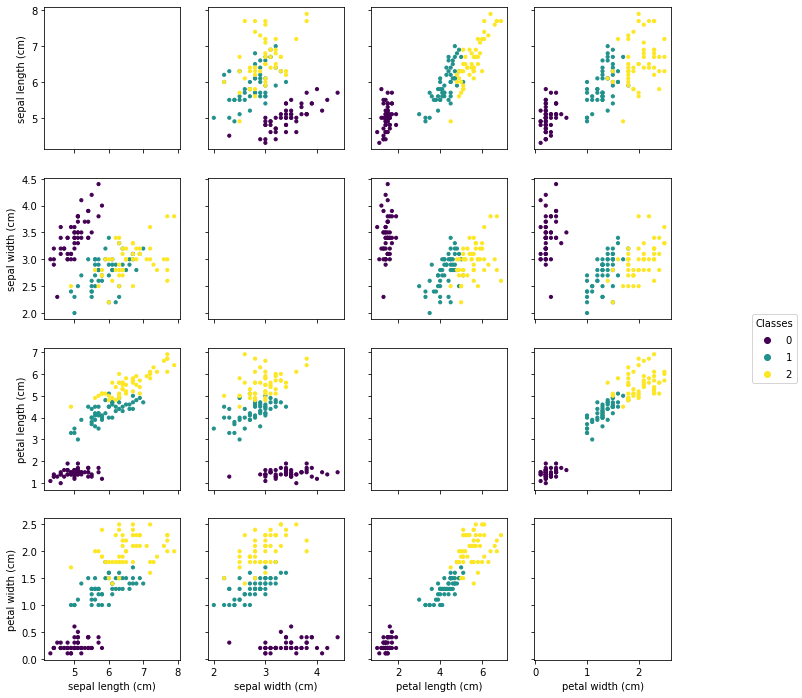

In [9]:
from matplotlib import pyplot as plt

num_features = features.shape[1]
fig, axes = plt.subplots(num_features, num_features, sharex="col", sharey="row", figsize=(12, 12))

for row in range(num_features):
    for col in range(num_features):
        if row == num_features - 1:
            axes[row, col].set_xlabel(iris_data.feature_names[col])
        if col == 0:
            axes[row, col].set_ylabel(iris_data.feature_names[row])
        if row == col:
            continue
        else:
            scatter = axes[row, col].scatter(features[:, col], features[:, row], c=labels, s=10)

fig.legend(*scatter.legend_elements(), title="Classes", loc="center right")
plt.subplots_adjust(right=0.85)

From the plots we see that class `0` is well separable from other two classes and classes `1` and `2` sometimes are mixed, especially when you consider the "sepal width" feature.

Let's next see how classical machine learning handles this dataset. 

## 2. Training a Classical Machine Learning Model

Before we actually train a model we should split the dataset into two parts: a training dataset and a test dataset. The former we use to train a model, the latter we use to verify how well our models perform on unseen data.

As usual, we ask scikit-learn to do the boring job for us. We also fix the seed to get reproducible results.

In [7]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

We train a classical Support Vector Classifier from scikit-learn. For a sake of simplicity we don't tweak any parameters and rely on the default values.

In [8]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)   # suppress printing the return value

Now we check out how well our classical model performs.

In [8]:
train_score = svc.score(train_features, train_labels)
test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score:.2f}")
print(f"Classical SVC on the test dataset:     {test_score:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


As can be seen from the scores the classical SVC algorithm performs very well. Next up it's time to look at quantum machine learning models.

## 3. Training a Quantum Machine Learning Model

As a quantum model we'll train a variational quantum classifier. This is the simplest available classifier in Qiskit Machine Learning and it can be a good starting point for newcomers to quantum machine learning with a background in classical machine learning.

But before we actually train a model, let's explore what `VQC` consists of. Two of its most important parts are the feature map and ansatz. What these are will now be explained.

Our data is classical. That means, we have our data as set of bits, not qubits. We need a way to encode the data onto the qubits. This is a very crucial process if we want to obtain a successful quantum model. This process is usually referred to as data encoding, data embedding or loading, or a feature map. This process does not appear in classical machine learning as we operate in the classical world only.

Then, once the data is loaded we have to apply a parameterized quantum circuit straight after the loading part. This circuit is a direct analogue of the layers of classical neural networks. It has a set of tunable parameters or weights. The weights are optimized to minimize an objective function defined by correctness of classification of known labelled data. A parameterized quantum circuit is also called parameterized trial state, variational form or ansatz. Perhaps, the latter is the most widely used term.

For more information we encourage the reader to take a look at the [Quantum Machine Learning Course](https://learn.qiskit.org/course/machine-learning).

As a feature map we consider a ``ZZFeatureMap``. This is one of the standard feature maps available in Qiskit circuit library. We pass `num_features` as `feature_dimension`, that means the feature map will have `num_features` or `4` qubits.

We decompose the feature map into the gates to give the reader a flavor what feature maps may look like.

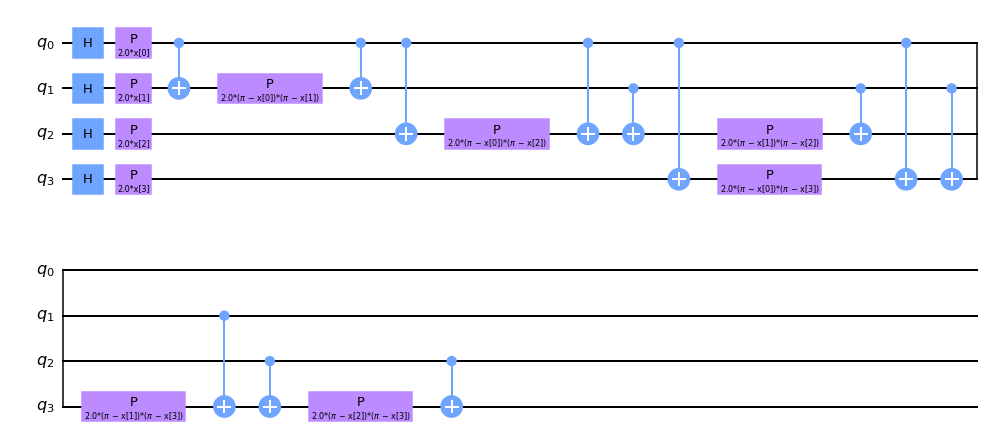

In [9]:
from qiskit.circuit.library import ZZFeatureMap

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

If you take a close look at the feature map you notice parameters `x[0], ..., x[3]`. These are placeholders for our features.

Now we create and plot our ansatz. Pay attention at the repetitive structure of the ansatz circuit, it is defined by the `reps` parameter.

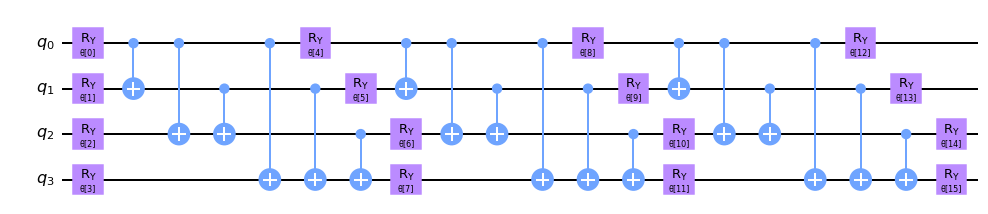

In [10]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

This circuit has 16 parameters names as `θ[0], ..., θ[15]`. These are our trainable weights of the classifier.

Then, we choose an optimization algorithm we'll use in the training process. This is pretty similar to what you may find in classical deep learning frameworks. To make the training process faster we choose a gradient free optimizer. You may explore other optimizers available in Qiskit.

In [11]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

We also fix initial values for weights. This is the point the optimization process will start from.

In [12]:
import numpy as np

initial_point = np.asarray([0.5] * ansatz.num_parameters)

On the next step we define where our classifier will be trained. It can be a simulator or a real quantum computer. Here, we use a simulator. We fix the seeds for reproducibility purposes and as quantum computers are noisy and probabilistic by their nature we set shots to 1024 to sample results from many runs or shots of the same circuit.

In [13]:
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance

quantum_instance = QuantumInstance(
    AerSimulator(),
    shots=1024,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)

We will add a callback function called `callback_graph`. This will be called for each objective value evaluation in the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [14]:
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we are ready to construct the classifier and fit it. 

`VQC` stands for "variational quantum classifier", it takes a feature map and an ansatz and constructs an instance of `CircuitQNN` automatically. In the simplest case it is enough to pass the number of qubits and a quantum instance to construct a valid classifier. The `CircuitQNN` directly takes the quantum circuit’s measurements as output without an observable. The output can be used either as a batch of samples, i.e., a list of bitstrings measured from the circuit’s qubits, or as a sparse vector of the resulting sampling probabilities for each bitstring.

Training may take some time, please, be patient.

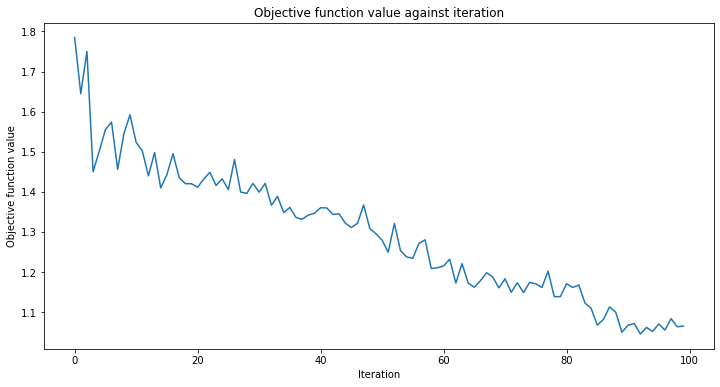

Training time: 330 seconds


In [15]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    quantum_instance=quantum_instance,
    initial_point=initial_point,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

Let's see how the quantum model performs on the real life dataset.

In [16]:
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score:.2f}")

Quantum VQC on the training dataset: 0.89
Quantum VQC on the test dataset:     0.90


As we can see the scores are high and the model can be used to predict labels on unseen data.

Now let's see what we can tune to get even better models.

- The key components are feature map and ansatz. You can tweak parameters, in our case you may change the `reps` parameter that specifies how many times a repetitive gate pattern is added to the circuit. Larger values lead more entanglement operation and more parameter. Thus, the model can be more flexible. On the other hand, the model can be overfitted. You can also try other feature maps and ansatzes, take a look at `NLocal` this is a super class for the feature map and ansatz we applied in the model. The sub-classes of `NLocal` can be used as a feature map or ansatz out of box, or you can come up with custom circuits.
- You may try other optimizers, Qiskit contains a bunch of them. Some of them are gradient free, some not. If you choose a gradient based optimizer, e.g., `L_BFGS_B` expect that the training time increases. Such optimizers additionally to the objective function evaluate gradient with respect to training parameters and this leads to an increased number of circuit executions per iteration.
- Another option is to randomly (or may be not randomly) sample `initial_point` and fit the model several times.

But what if a dataset contains too many features modern quantum computers can handle?

## 4. Reducing the Number of Features

In this section we reduce the number of features in our dataset and train our models again. We'll move at a faster pace as the steps are the same except the first one where we apply a PCA transformation. 

We transform our 4 features into 2 features only. Now, we can easily plot these 2 features on a single figure.

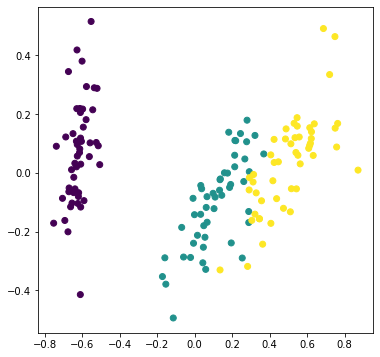

In [17]:
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
plt.scatter(features[:, 0], features[:, 1], c=labels)

As usual, we split the dataset first, then fit a classical model.

In [18]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

svc.fit(train_features, train_labels)

train_score = svc.score(train_features, train_labels)
test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score:.2f}")
print(f"Classical SVC on the test dataset:     {test_score:.2f}")

Classical SVC on the training dataset: 0.97
Classical SVC on the test dataset:     0.90


The results are still good, but slightly worse compared to the initial version. Let's see how a quantum model deals with them.

This time we apply another ansatz and increase `reps` from the default `3` to `4` to have more trainable parameters and keep the same type of the feature type. Recall, we have `2` qubits now, so we have to recreate the feature map.

In [19]:
from qiskit.circuit.library import EfficientSU2

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)

ansatz = EfficientSU2(num_qubits=num_features, reps=4)

We also reduce the maximum number of iterations we run the optimization process, we expect it to converge faster as we have less qubits now. 

As well, we re-sample `initial_point` to adjust to the new ansatz.

In [20]:
optimizer = COBYLA(maxiter=50)

initial_point = np.asarray([0.5] * ansatz.num_parameters)

Now we construct a quantum classifier out the new parameters and train it.

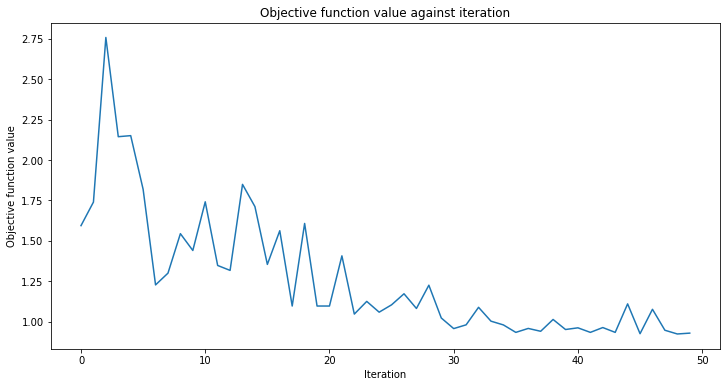

Training time: 106 seconds


In [21]:
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    quantum_instance=quantum_instance,
    initial_point=initial_point,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [22]:
train_score = vqc.score(train_features, train_labels)
test_score = vqc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score:.2f}")

Quantum VQC on the training dataset: 0.75
Quantum VQC on the test dataset:     0.80


Well, the scores are nice, but could be better. Perhaps, if had more iterations we could do better. In machine learning, whether it is quantum or classical, there are a lot of ways to improve models.

In [23]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright